In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns=40

In [3]:
df=pd.read_csv("girlgeneration(utf8).csv")

# 搖滾區：共有1669張票
# 非搖滾區：共有5400張

### Q1. Split the data into two groups => with and without seats (非搖滾與搖滾區)
- 座位編號是空值的

In [6]:
len(df[df["SEAT_REGION_NAME"].str.contains("FloorB1")])

2581

In [ ]:
# 搖滾區位置各多一個

In [8]:
mask1=df["SEAT_ROW"].isnull() 
mask2=df["SEAT_REGION_NAME"].str.contains("FloorB1FloorSectionD")
len(df[mask1 & mask2])

353

In [4]:
# 1 代表有座位，0 代表沒座位
seat_exist=pd.get_dummies(df["SEAT_REGION_NAME"].str.contains("FloorB1"),drop_first=False)[False]

In [5]:
df["WITH_SEAT"]=seat_exist
df["WITH_SEAT"]=df["WITH_SEAT"].map({1:"A",0:"B"})

In [6]:
df.head(3)

,SERIAL_ID,ORDER_ID,TICKET_ITEM_ID,PRINT_TIMES,IDENTITY,PROGRAM_ID,PROGRAM_NAME,CREATE_DATE,PLAY_DATE,PLAY_TIME,TICKET_BOOTH_RUNNING_NUM,PRICE,T_STANDARD_TICKET_TYPE_NAME,SEAT_REGION_NAME,FLOOR_NO,SEAT_ROW,SEAT_NO,TICKET_SHIPPING_RATE_ID,TICKET_FEE,SHIPPING_ZIP1,SHIPPING_COUNTRY_ID1,SHIPPING_TOWN_ID1,RECEIPT_TITLE,SHIPPING_COUNTRY_ID2,SHIPPING_TOWN_ID2,SHIPPING_ZIP2,ORDER_NUM,TICKET_ENTRANCE_NO,SEX,ADDRESS,WITH_SEAT
0,331,26237,52196,2,K12197,11,Girls Generation. THE lst ASIA TOUR Into the n...,2010/10/14 p.m. 11:25:58.,2010/10/17,15:00,41139,1800,non-member,Floor3Sectionyellow3I,1,11.0,10.0,4,50,114.0,1,10,NaN,5,61,300.0,26237,0,male,2103,A
1,332,26237,52195,2,K12197,11,Girls Generation. THE lst ASIA TOUR Into the n...,2010/10/14 p.m. 11:25:58.,2010/10/17,15:00,41138,1800,non-member,Floor3Sectionyellow3I,1,11.0,11.0,4,50,114.0,1,10,NaN,5,61,300.0,26237,0,male,2103,A
2,378,24923,46903,3,L22289,11,Girls Generation. THE lst ASIA TOUR Into the n...,2010/9/18 p.m. 11:26:37.,2010/10/17,15:00,39579,1800,member,Floor3Sectionyellow3C,1,25.0,7.0,2,50,434.0,10,129,NaN,10,129,434.0,24923,0,male,2682,A


In [7]:
selected_features=["CREATE_DATE","PRICE","ORDER_ID","T_STANDARD_TICKET_TYPE_NAME","SEAT_REGION_NAME","WITH_SEAT"]

In [8]:
data=df[selected_features].rename(columns={"T_STANDARD_TICKET_TYPE_NAME":"MEMBER_TYPE","seat_exist":"WITH_SEAT"}).copy()

In [9]:
# 非搖滾區共有
print("A",len(data[data["WITH_SEAT"]=="A"]))

# 搖滾區共有
print("B",len(data[data["WITH_SEAT"]=="B"]))

A 5400
B 1669


# 2.Data Preprocessing
- 2.1 convert time feature to panda's time object
- 2.2 Add total tickets 

In [10]:
def convertTimeObject(row):
    date=row.split(" ")[0]
    time=row.split(" ")[2].replace(".","")
    p=row.split(" ")[1].replace(".","")
    timeObj=date+" "+time+" "+p
    return timeObj

In [11]:
data.CREATE_DATE=pd.DatetimeIndex(data.CREATE_DATE.apply(convertTimeObject))

In [12]:
data.set_index("CREATE_DATE",inplace=True)
data.sort_index(ascending=True,inplace=True)

In [13]:
data.sort_index(ascending=True,inplace=True)

### 2.2 comput total tickets depending in current selling situations


In [14]:
# 非搖滾區共有
print("A",len(data[data["WITH_SEAT"]=="A"]))
# 搖滾區共有
print("B",len(data[data["WITH_SEAT"]=="B"]))

A 5400
B 1669


In [15]:
AT=len(data[data["WITH_SEAT"]=="A"])
BT=len(data[data["WITH_SEAT"]=="B"])

In [16]:
S=["A","B"]
tic=[AT-1,BT-1]
total=dict(zip(S,tic))

In [17]:
# 計算個別販售狀況的票數
tickets=[]
for tp in data["WITH_SEAT"]:
    cur_num = total[tp]
    tickets.append(cur_num)
    total[tp]-=1
data["CUR_TICKET"]=tickets

In [18]:
# 計算總票數
data["Total"]=data["WITH_SEAT"].map({"A":AT,"B":BT})

In [19]:
data["Frequency"]=data["CUR_TICKET"]/data["Total"]

# Q2. Selling Speed Analyze The A and B for T1 T2
- T1 (12:00 -16:00 PM on Sept 18 2010)
- T2 (16:00-20:00 Sept. 18 .2010)

# 圖形化

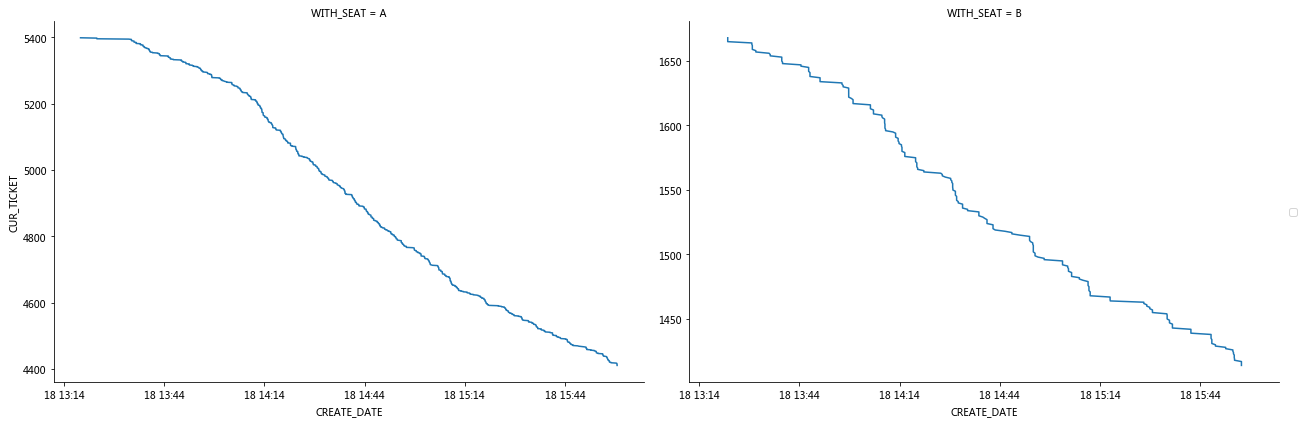

In [20]:
T1=data.truncate("2010-09-18 12:00:00","2010-09-18 16:00:00").copy()
Tt1=T1.reset_index().copy()
g=sns.FacetGrid(data=Tt1,col="WITH_SEAT",size=6,aspect=1.5,sharey=False,col_order=["A","B"])
g.map(plt.plot,"CREATE_DATE","CUR_TICKET")
g.add_legend()

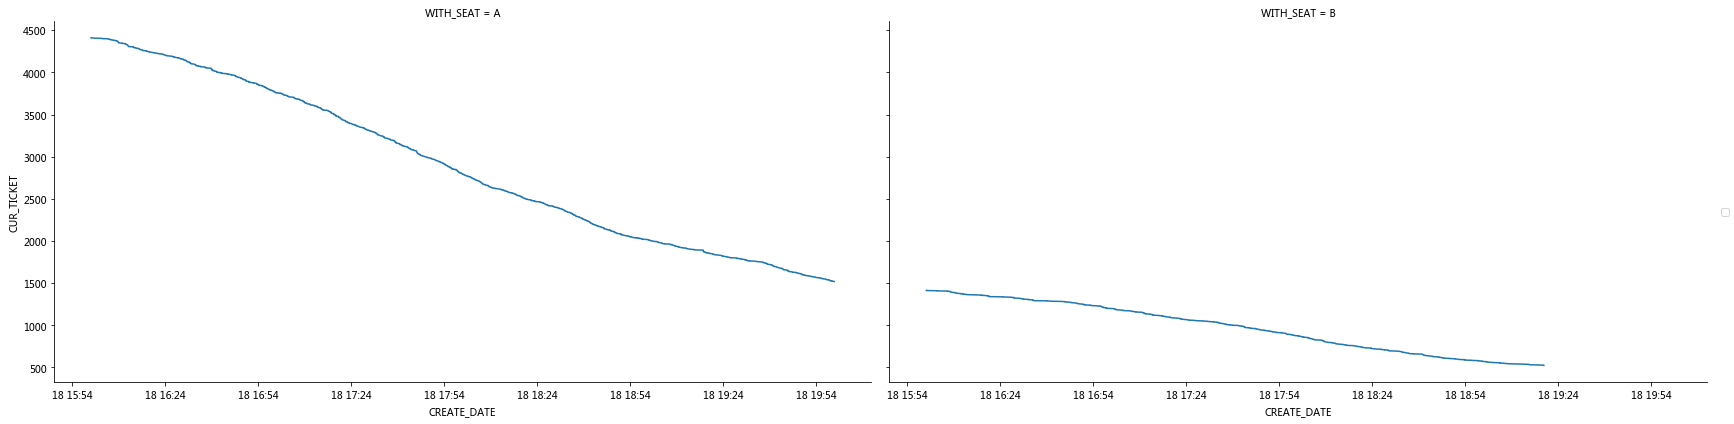

In [21]:
T2=data.truncate("2010-09-18 16:00:00","2010-09-18 20:00:00").copy()
#T2.reset_index(inplace=True)
Tt2=T2.reset_index().copy()
g=sns.FacetGrid(data=Tt2,col="WITH_SEAT",size=6,aspect=2,sharey=True,col_order=["A","B"])
g.map(plt.plot,"CREATE_DATE","CUR_TICKET")
g.add_legend()

# 數據化

In [22]:
def computeSellingSpeed(data,dataname,mask):
    if dataname=="T1":
        timeName="2010-09-18 12:00:00-16:00:00"
    else:
        timeName="2010-09-18 16:00:00-20:00:00"
    
    start_time=data[data["WITH_SEAT"]==mask]["CUR_TICKET"].idxmax()
    end_time=data[data["WITH_SEAT"]==mask]["CUR_TICKET"].idxmin()
    start_ticket=data[data["WITH_SEAT"]==mask]["CUR_TICKET"].max()
    end_ticket=data[data["WITH_SEAT"]==mask]["CUR_TICKET"].min()
    
    #計算時間變化量
    timeDelta=end_time-start_time
    timeDelta=round(timeDelta.seconds/3600,2)
    
    # 計算販售票數變化量與平均
    ticketDelta=start_ticket-end_ticket+1
    average=round(ticketDelta/timeDelta,2)
    
    str1="該時段起始時間至最後區間為：{} -> {}，販售票數變化狀況：{} -> {}".format(start_time,end_time,start_ticket,end_ticket)
    str2="{} in {} ({})\n共銷售{}張，時間{}小時，\n平均一小時販售{}張：".format(mask,dataname,timeName,ticketDelta,timeDelta,average)
    return str1+"\n"+str2

In [23]:
print(computeSellingSpeed(T1,"T1","A"),"\n")
print(computeSellingSpeed(T1,"T1","B"),"\n")
print(computeSellingSpeed(T2,"T2","A"),"\n")
print(computeSellingSpeed(T2,"T2","B"),"\n")

該時段起始時間至最後區間為：2010-09-18 13:18:55 -> 2010-09-18 15:59:37，販售票數變化狀況：5399 -> 4411
A in T1 (2010-09-18 12:00:00-16:00:00)
共銷售989張，時間2.68小時，
平均一小時販售369.03張： 

該時段起始時間至最後區間為：2010-09-18 13:22:33 -> 2010-09-18 15:56:24，販售票數變化狀況：1668 -> 1414
B in T1 (2010-09-18 12:00:00-16:00:00)
共銷售255張，時間2.56小時，
平均一小時販售99.61張： 

該時段起始時間至最後區間為：2010-09-18 16:00:07 -> 2010-09-18 19:59:54，販售票數變化狀況：4410 -> 1519
A in T2 (2010-09-18 16:00:00-20:00:00)
共銷售2892張，時間4.0小時，
平均一小時販售723.0張： 

該時段起始時間至最後區間為：2010-09-18 16:00:05 -> 2010-09-18 19:19:20，販售票數變化狀況：1413 -> 524
B in T2 (2010-09-18 16:00:00-20:00:00)
共銷售890張，時間3.32小時，
平均一小時販售268.07張： 



# Q3.  define a new measurement to estimate the " system loading"  (how busy the system is) during  T1

In [24]:
mask=T1["WITH_SEAT"]=="A"
mask1=T1["WITH_SEAT"]=="B"

## 3.1 define the function to compute system loading in another angle 

In [25]:
# 同一個 ORDER_ID代表這些票數是同一個人訂的，若不連號，代表有人訂但沒訂到，每訂幾張或是每個人
def computeBusy(data,dataname,mask,viewpoint):
    ma=data["WITH_SEAT"]==mask
    
    # show info 
    print(dataname,":",viewpoint)
    #print("共有幾張票售出 : ",len(data[ma]))
    print("編號 Range : ",data[ma]["ORDER_ID"].max()-data[ma]["ORDER_ID"].min())
    print("編號不重複數: ",len(data[ma]["ORDER_ID"].value_counts()))
    print("總共流失多少人:",data[ma]["ORDER_ID"].max()-data[ma]["ORDER_ID"].min()-len(data[ma]["ORDER_ID"].value_counts()))
    dif=[]
    dih=[]
    count=1
    
    if viewpoint=="票數觀點":
        ind=data[ma]["ORDER_ID"]
       
        # 並不會知道那些斷掉的人訂了多少張票
        for index in range(0,len(ind)-1):
            if ind[index+1]-ind[index]>1:
                dif.append(count)
                count=1
            else:
                count+=1 #紀錄連續的票數
        return "{} in {}:\n平均能承受的最大連續訂票張數:{}\n平均能承受訂票張數:{}".format(mask,dataname,np.max(dif),round(np.mean(dif),3))
    elif viewpoint=="人數觀點":
        ind=data[ma]["ORDER_ID"].value_counts().sort_index().index
       
        for index in range(0,len(ind)-1):
            if ind[index+1]-ind[index]>1: # 代表不連號
                dif.append(count)
                count=1
            else:
                count+=1
   
        for index in range(0,len(ind)-1):
            if ind[index+1]-ind[index]>1: # 代表不連號
                dih.append(ind[index+1]-ind[index])
            else:
                pass
        return "{} in {}:\n共跳號幾次:{}\n最大能承受的請求數(人數):{}\n平均能承受的請求數(人數):{}\n最大流失多少人:{}\n平均流失多少人:{}".format(mask,dataname,np.size(dif),np.max(dif),round(np.mean(dif),3),np.max(dih),round(np.mean(dih),3))
        
        

## 3.2 Result

In [26]:
#已新增票數的角度去看
print(computeBusy(T1,"T1","A","票數觀點"),"\n-----------------\n")
print(computeBusy(T1,"T1","B","票數觀點"),"\n-----------------\n")
print(computeBusy(T2,"T2","A","票數觀點"),"\n-----------------\n")
print(computeBusy(T2,"T2","B","票數觀點"),"\n-----------------\n")

T1 : 票數觀點
編號 Range :  567
編號不重複數:  390
總共流失多少人: 177
A in T1:
平均能承受的最大連續訂票張數:27
平均能承受訂票張數:7.605 
-----------------

T1 : 票數觀點
編號 Range :  554
編號不重複數:  94
總共流失多少人: 460
B in T1:
平均能承受的最大連續訂票張數:13
平均能承受訂票張數:3.392 
-----------------

T2 : 票數觀點
編號 Range :  2249
編號不重複數:  1296
總共流失多少人: 953
A in T2:
平均能承受的最大連續訂票張數:31
平均能承受訂票張數:4.915 
-----------------

T2 : 票數觀點
編號 Range :  2043
編號不重複數:  426
總共流失多少人: 1617
B in T2:
平均能承受的最大連續訂票張數:10
平均能承受訂票張數:2.614 
-----------------



In [27]:
#計算連續與斷裂的平均
print(computeBusy(T1,"T1","A","人數觀點"),"\n-----------------\n")
print(computeBusy(T1,"T1","B","人數觀點"),"\n-----------------\n")
print(computeBusy(T2,"T2","A","人數觀點"),"\n-----------------\n")
print(computeBusy(T2,"T2","B","人數觀點"),"\n-----------------\n")

T1 : 人數觀點
編號 Range :  567
編號不重複數:  390
總共流失多少人: 177
A in T1:
共跳號幾次:127
最大能承受的請求數(人數):11
平均能承受的請求數(人數):3.047
最大流失多少人:6
平均流失多少人:2.402 
-----------------

T1 : 人數觀點
編號 Range :  554
編號不重複數:  94
總共流失多少人: 460
B in T1:
共跳號幾次:73
最大能承受的請求數(人數):4
平均能承受的請求數(人數):1.274
最大流失多少人:29
平均流失多少人:7.315 
-----------------

T2 : 人數觀點
編號 Range :  2249
編號不重複數:  1296
總共流失多少人: 953
A in T2:
共跳號幾次:544
最大能承受的請求數(人數):14
平均能承受的請求數(人數):2.377
最大流失多少人:11
平均流失多少人:2.754 
-----------------

T2 : 人數觀點
編號 Range :  2043
編號不重複數:  426
總共流失多少人: 1617
B in T2:
共跳號幾次:334
最大能承受的請求數(人數):5
平均能承受的請求數(人數):1.272
最大流失多少人:27
平均流失多少人:5.844 
-----------------

